In [1]:
import sys
sys.path.append('../..')

from bitarray import bitarray
import time
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
import navbench as nb
from navbench import improc as ip
from navbench import navigation as nv
import numpy as np
from scipy.spatial import distance
import utm



dbroot = '../../../../../../media/norbert/26a2bc17-d872-44cd-9cbc-d1d336896751/dataset/'
#dbroot = '../../../../../../media/dataset/'

In [5]:
directories = [x[0] for x in os.walk(dbroot)]
directories =  sorted(directories)
dataframes = []
for i in range(1, len(directories)):
    print(directories[i])
  #  df = pd.read_csv(dbroot + directories[i]+ "/database_entries.csv") 
   # dataframes.append(df)

../../../../../../media/norbert/26a2bc17-d872-44cd-9cbc-d1d336896751/dataset/imgdataset_02-03-2021_15-51-22
../../../../../../media/norbert/26a2bc17-d872-44cd-9cbc-d1d336896751/dataset/imgdataset_02-03-2021_15-51-22/unwrapped_images
../../../../../../media/norbert/26a2bc17-d872-44cd-9cbc-d1d336896751/dataset/imgdataset_02-03-2021_16-26-23
../../../../../../media/norbert/26a2bc17-d872-44cd-9cbc-d1d336896751/dataset/imgdataset_02-03-2021_16-26-23/unwrapped_images
../../../../../../media/norbert/26a2bc17-d872-44cd-9cbc-d1d336896751/dataset/imgdataset_03-03-2021_15-3-14
../../../../../../media/norbert/26a2bc17-d872-44cd-9cbc-d1d336896751/dataset/imgdataset_03-03-2021_15-3-14/unwrapped_images
../../../../../../media/norbert/26a2bc17-d872-44cd-9cbc-d1d336896751/dataset/imgdataset_03-03-2021_15-37-49
../../../../../../media/norbert/26a2bc17-d872-44cd-9cbc-d1d336896751/dataset/imgdataset_03-03-2021_15-37-49/unwrapped_images
../../../../../../media/norbert/26a2bc17-d872-44cd-9cbc-d1d336896751/d

In [30]:
ldir = '../../../../../../media/norbert/26a2bc17-d872-44cd-9cbc-d1d336896751/dataset/imgdataset_08-03-2021_12-21-25'
for filename in os.listdir(ldir):
    root, ext = os.path.splitext(filename)
    if root.startswith('unwrapped_image') and ext == '.jpg':
        print(filename)
        shutil.move(ldir + '/' + filename, ldir + '/unwrapped_images')


In [27]:
''

''

In [12]:

coordinates = []
for i in range(0, len(dataframes)) :
    dataset_coord = []
    dfx = dataframes[i]["X [mm]"]
    dfy = dataframes[i]["Y [mm]"]
    dataset_coord.append(dfx)
    dataset_coord.append(dfy)
    coordinates.append(dataset_coord)
    

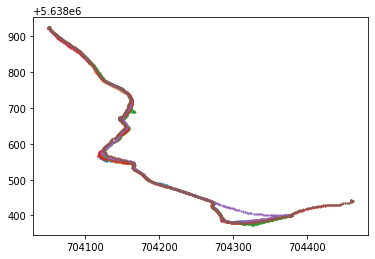

In [13]:
skipframe = 10
markersize = 1
marker = 'o'

_, ax = plt.subplots()
for i in coordinates : 
    ax.scatter(i[0][::skipframe],i[1][::skipframe],marker=marker, s=markersize)
 

In [3]:

# comparing routes with dct 
def get_rotations(im) :
    length = len(im[0])
    rotated_ims = []
    for rot in range(1, length) :
        rotated = np.roll(im, -rot, axis=1)
        rotated_ims.append(rotated)
    return rotated_ims

def angle_diff(a, b) :
    return 180 - math.fabs(math.fmod(math.fabs(a - b), 2*180) - 180)

def create_training_matrix(referene_imgs) :
    hash_ref_matrix = []
    for im in referene_imgs :
        im_rots = get_rotations(im)
        rotated_hashes = []
        for r in im_rots :
          
            rotated_hashes.append(ip.dct_hash(r)*1)
        hash_ref_matrix.append(rotated_hashes)
    return hash_ref_matrix



In [17]:
db1 = nb.Database(directories[4])
ims = db1.read_images(preprocess=ip.resize(360,110))








Loading database at ../../../../../../media/norbert/26a2bc17-d872-44cd-9cbc-d1d336896751/dataset/imgdataset_03-03-2021_15-37-49...


In [35]:
tm = create_training_matrix(ims)

KeyboardInterrupt: 

In [4]:
import shutil, os
for i in range(1, len(directories)):
    dir = directories[i]
    dirname = (directories[i] + "/unwrapped_images")
    print(dirname)

    
   

../../../../../../media/norbert/26a2bc17-d872-44cd-9cbc-d1d336896751/dataset/imgdataset_02-03-2021_15-51-22/unwrapped_images
unwrapped_image7063.jpg


FileNotFoundError: [Errno 2] No such file or directory: 'unwrapped_image7063.jpg'

In [37]:
os.getcwd()

'/home/norbert/navbench/analysis/long_route'

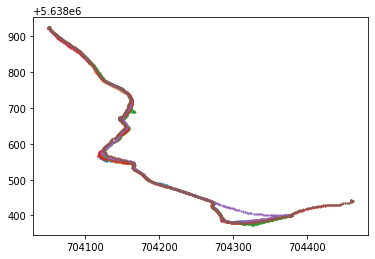

In [71]:
_, ax = plt.subplots()

offs = x1[0]
offsy = y1[0]

x1f = (x1 - offs) /1000
x2f = (x2 - offs) /1000
x3f = (x3 - offs) /1000
x4f = (x4 - offs) /1000
x5f = (x5 - offs) /1000
x6f = (x6 - offs) /1000
x7f = (x7 - offs) /1000
x8f = (x8 - offs) /1000
x9f = (x9 - offs) /1000
x10f = (x10 - offs) /1000
x11f = (x11- offs) /1000


y1f = (y1 - offsy) /1000
y2f = (y2 - offsy) /1000
y3f = (y3 - offsy) /1000
y4f = (y4 - offsy) /1000
y5f = (y5 - offsy) /1000
y6f = (y6 - offsy) /1000
y7f = (y7 - offsy) /1000
y8f = (y8 - offsy) /1000
y9f = (y9 - offsy) /1000
y10f = (y10 - offsy) /1000
y11f = (y11 - offsy) /1000



skipframe = 10
markersize = 5
marker = 'o'
ax.plot(x1f,y1f)
ax.scatter(x2f[::skipframe],y2f[::skipframe],marker=marker, s=markersize)
ax.scatter(x3f[::skipframe],y3f[::skipframe],marker=marker, s=markersize)
ax.scatter(x4f[::skipframe],y4f[::skipframe],marker=marker, s=markersize)
ax.scatter(x5f[::skipframe],y5f[::skipframe],marker=marker, s=markersize)
ax.scatter(x6f[::skipframe],y6f[::skipframe],marker=marker, s=markersize)
ax.scatter(x7f[::skipframe],y7f[::skipframe],marker=marker, s=markersize)
ax.scatter(x8f[::skipframe],y8f[::skipframe],marker=marker, s=markersize)
ax.scatter(x9f[::skipframe],y9f[::skipframe],marker=marker, s=markersize)
ax.scatter(x10f[::skipframe],y10f[::skipframe],marker=marker, s=markersize)
ax.scatter(x11f[::skipframe],y11f[::skipframe],marker=marker, s=markersize)



plt.title('routes in the open environment')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.legend(legend)



NameError: name 'x1' is not defined

In [62]:
def get_min_dist_between(xx1,yy1,xx2,yy2) :
    sm = []
    for i in range(0, len(xx1)) : 
        temp = []
        for j in range(0, len(xx2)) :
            temp.append(math.sqrt( (xx2[j]-xx1[i])**2 + (yy2[j]-yy1[i])**2 ))
        sm.append(min(temp)/1000)

    c_sm = [x for x in sm if str(x) != 'nan']
    return c_sm


In [29]:
""

''

Text(0, 0.5, 'Distance (m)')

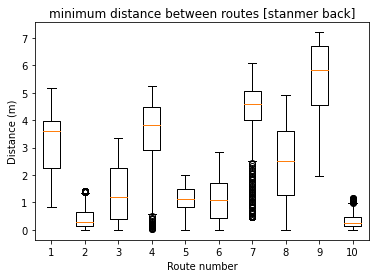

In [68]:
plt.boxplot([
    get_min_dist_between(x1,y1,x2,y2),
    get_min_dist_between(x1,y1,x3,y3),
    get_min_dist_between(x1,y1,x4,y4),
    get_min_dist_between(x1,y1,x5,y5),
    get_min_dist_between(x1,y1,x6,y6),
    get_min_dist_between(x1,y1,x7,y7),
    get_min_dist_between(x1,y1,x8,y8),
    get_min_dist_between(x1,y1,x9,y9),
    get_min_dist_between(x1,y1,x10,y10),
    get_min_dist_between(x1,y1,x11,y11),
    ])
plt.title("minimum distance between routes [stanmer back]")
plt.xlabel('Route number')
plt.ylabel('Distance (m)')

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff06080c860>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff0645ab7b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff06080c4a8>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff0645abc50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff064b94588>],
 'means': []}

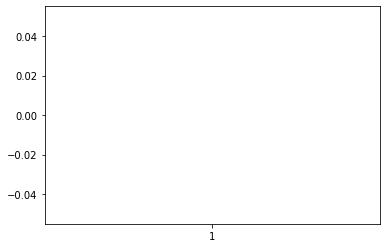

In [32]:
plt.boxplot(smallest1)

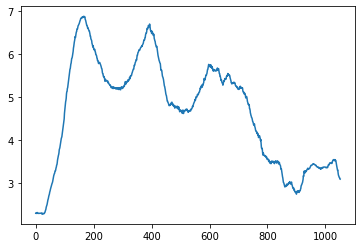

In [65]:
plt.plot(get_min_dist_between(x6,y6,x8,y8))

In [23]:
c_small1 = [x for x in smallest1 if str(x) != 'nan']
c_small2 = [x for x in smallest2 if str(x) != 'nan']
c_small3 = [x for x in smallest3 if str(x) != 'nan']

In [9]:
import glob, shutil

for i in glob.glob('../../../../../../media/dataset/unwrapped*'):
  shutil.move(i, 'new_dir/' + i)

'/home/norbert/navbench/analysis/long_route'

NameError: name 'pwd' is not defined